In [348]:
import numpy as np
import lammps
from lammps import LMP_STYLE_ATOM, LMP_TYPE_ARRAY
import matplotlib.pyplot as plt


# This a wrapper function and should be used with caution:
# Periodic datasets with  lammps-format style atomic is currently supported
# Wishlist:- a fitSNAP and LAMMPS-provided descriptor extraction function 

EIGHT_TW0_JMAX = 55
SIX_TW0_JMAX = 30

def compute_bispectrum(lmp_struc, cutfac, rfrac0, twojmax, R, w):
    '''
    Hyper-parmaters:

    cutfac = scale factor applied to all cutoff radii (positive real) : float

    rfac0 = parameter in distance to angle conversion (0 < rcutfac < 1) : float

    twojmax = band limit for bispectrum components (non-negative integer) : int

    R_1, R_2,… = list of cutoff radii, one for each type (distance units) : list

    w_1, w_2,… = list of neighbor weights, one for each type : list
    
    Returns
    --------
    BiSpec: Bispectrum components for each atoms
    '''

    lmp = lammps.lammps(cmdargs=['-sc','.lammps_output.txt', '-l', 'None'])
    
    R_max = max(R)
    R = ' '.join(map(str, R))
    w = ' '.join(map(str, w))
    
    
    doctring = f"""
    #LAMMPS input file
    # ------------------------ INITIALIZATION ----------------------------
    processors    * * *
    units         metal
    dimension    3
    boundary    p    p    p
    atom_style   atomic
    box tilt large
    #--------------------------- LAMMPS Data File -------------------------
    read_data     {lmp_struc}
    mass * 1.0
    #--------------------------- DUMMY FORCE_FIELD -------------------------
    pair_style      zero {cutfac*R_max*2}
    pair_coeff      * *  
    
    """
    try:
        lmp.commands_string(doctring)
    except Exception as e:
        raise RuntimeError(f'LAMMPS: {e}\n')

    #-------- Compute SNAP descriptors ---------------------        
    lmp.command(f'compute BiSpec all sna/atom {cutfac} {rfrac0} {twojmax} {R} {w}')
    
    try:
        lmp.command('run 0')
    except Exception as e:
        raise RuntimeError(f'LAMMPS: {e}\n')

	#-------- Extract SNAP descriptors ---------------------
    Natoms = lmp.get_natoms()
    print ((f'Number of atoms in the system: {Natoms}'))
    
    if twojmax==8:
        snap_shape = (Natoms, EIGHT_TW0_JMAX)
    elif twojmax==6:
        snap_shape = (Natoms, EIGHT_TW0_JMAX)
    else:
        ValueError(f'Unsupported twojmax value: {twojmax}. Supported values are 6 or 8.')
    # data = lmp.extract_compute('BiSpec', LMP_STYLE_ATOM, LMP_TYPE_ARRAY)    
    # ptr = ctypes.cast(data, ctypes.POINTER(ctypes.c_double))
    # BiSpec = np.ctypeslib.as_array(ptr, shape=snap_shape)
    BiSpec = lmp.numpy.extract_compute('BiSpec', LMP_STYLE_ATOM, LMP_TYPE_ARRAY).copy()
          
    
    t = lmp.gather_atoms('type',0,1)
    types = np.ctypeslib.as_array(t)
    
    lmp.close()
    
    return BiSpec, types


def compute_decriptor_PCA(data, num_PC=3):
	"""
	Reduces descriptor dimensions by first standardizing the data and then applying PCA.
	
	Returns
	-------
	x: Principal components
	variances: Explained variance ratio of the principal components.
	"""
	from sklearn.decomposition import PCA
	from sklearn.preprocessing import StandardScaler
	scaling = StandardScaler()
	scaling.fit(data)
	Scaled_data = scaling.transform(data)
	Scaled_data = data
	principal = PCA(n_components=num_PC)
	principal.fit(Scaled_data)
	x = principal.transform(Scaled_data)
	variances = principal.explained_variance_ratio_
	return x, variances

def hellinger_from_kde(p_density, q_density, x_grid):
    # Ensure densities are numpy arrays
    p = np.asarray(p_density)
    q = np.asarray(q_density)
    
    # Normalize both densities (just to be safe)
    dx = x_grid[1] - x_grid[0]
    p /= np.sum(p * dx)
    q /= np.sum(q * dx)

    # Compute Hellinger distance
    h = (1 / np.sqrt(2)) * np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2) * dx)
    return h


from ovito.data import *
import numpy as np 
from traits.api import Union, Int, Enum, Bool
from ovito.pipeline import ModifierInterface
from itertools import combinations

class CalculateBondAnglesAtParticle(ModifierInterface):
   
    center_particle = Union(None, Int, label = "Compute for particle")
    mode = Enum("Index", "Identifier", label = "Choose particle by")
    bond_mode = Enum("Index", "Identifier", label = "List bonds by")

    def calculate_bond_angles(self, bond_vectors):
        b1 = bond_vectors[:,0]/np.linalg.norm(bond_vectors[:,0], axis = 1)[:, None]
        b2 = bond_vectors[:,1]/np.linalg.norm(bond_vectors[:,1], axis = 1)[:, None]
        return np.degrees(np.arccos(np.sum(b1*b2, axis = 1)))
    
    def calculate_bond_vector_combinations(self, data, particle):
        # Create bonds enumerator object.
        bonds_enum = BondsEnumerator(data.particles.bonds)
        # List of bond indices of all bonds at the current particle
        bonds_of_particle = [bond_index for bond_index in bonds_enum.bonds_of_particle(particle)]
        if len(bonds_of_particle) < 2:
            raise RuntimeError("Not enough bonds found to compute angles.")
        # All possible bond pairs in bonds_of_particle list
        bond_pairs = list(combinations(bonds_of_particle, 2))
        # Look up corresponding bond vectors
        topo = data.particles.bonds.topology[bond_pairs] 
        # Flip bond vector if current particle is not index 0 in topology pairs
        idx = np.where(topo[:,:,0] != particle)
        vectors = data.particles.bonds["Bond vectors"][bond_pairs]
        vectors[idx[0], idx[1]] *= -1
        # Get particle index triplets from topo [B,A][B,C]
        topo[idx[0], idx[1]] =  np.flip(topo[idx[0], idx[1]])
        triplets = np.column_stack((topo[:, 0, 1],topo[:, 1, :]))
        return bond_pairs, triplets, vectors
       
    def modify(self, data, **kwargs):

        if self.center_particle == None:
            return
        if self.mode == "Identifier" and "Particle Identifier" not in data.particles:
            raise RuntimeError("No Particle Identifiers in DataCollection. Deactivate Option <Output Particle Identifiers>.")
        if self.mode == "Identifier" and (np.isin(data.particles.identifiers, self.center_particle).any() == False):
            raise IndexError("Invalid Particle Identifier")
        if self.mode == "Index" and (self.center_particle >= data.particles.count or self.center_particle < 0):
            raise IndexError(f"Invalid Particle Index. Choose Index between 0 and {data.particles.count-1}.")
        if data.particles.bonds == None:
            raise RuntimeError("No Bonds in DataCollection. Please first generate bonds.")
        if self.bond_mode == "Identifier" and "Bond Identifier" not in data.particles.bonds:
            raise RuntimeError("No Bond Identifiers in DataCollection. Switch to Option <Output Bond Indices>.")

        # Look up bond indices of all bonds connected to current particle
        if self.mode == 'Identifier':
            particle = np.where(data.particles.identifiers == self.center_particle)[0][0]
        else:
            particle = self.center_particle

        # Calculate bond vectors for global topology array    
        positions = data.particles.positions
        topology = data.particles.bonds.topology
        bond_vectors = positions[topology[:,1]] - positions[topology[:,0]]
        if "Periodic Image" in data.particles.bonds:
            bond_vectors += np.dot(data.cell[:3,:3], data.particles.bonds.pbc_vectors.T).T
        data.particles_.bonds_.create_property("Bond vectors", data = bond_vectors)    
        # Get all possible combinations of bond pairs at one particle, the corresponding 
        # particle index triplets and bond vectors
        bond_pairs, triplets, v_b = self.calculate_bond_vector_combinations(data, particle)
        # Calculcate angles between all pairs of bond vectors
        angles = self.calculate_bond_angles(v_b)
        
        #Script output
        b = len(str(data.particles.bonds.count))
        p = len(str(data.particles.count))
        header = f"Triplet A-B-C{(2*p+10+len(str(particle))-13)*' '}Angle{7*' '}Bond Pair B1 - B2" 
        print(header)
        print(f"{'-'*len(header)}")
        for i in range(len(bond_pairs)):
            A,B,C = triplets[i]
            if self.mode == 'Identifier':
                A,B,C = data.particles.identifiers[[A, B, C]]
            output = f"{A:{p}d} - {B} - {C:<{p}d}    {angles[i]:<8.4f}" 
            B1, B2 = bond_pairs[i][0], bond_pairs[i][1]
            if self.bond_mode == 'Identifier':
                B1, B2 = int(data.particles.bonds['Bond Identifier'][B1]),int(data.particles.bonds['Bond Identifier'][B2])
            output+=f"    {B1:{b}d} - {B2:<{b}d}"
            print(output)
        
        # Store results as OVITO Data Table
        table = data.tables.create(
            identifier=f"bond-angles-{self.center_particle}",
            title=f"Bond Angles of Particle {self.center_particle}",
            plot_mode=DataTable.PlotMode.NoPlot)
        table.y = table.create_property('Angle', data=angles)
        if self.mode == 'Identifier':
            triplets = data.particles.identifiers[triplets]
        table.create_property('Particle Triplet', data=triplets, components=['A', 'B', 'C'])
    
        if self.bond_mode == 'Identifier':
            bond_pairs = data.particles.bonds['Bond Identifier'][bond_pairs]
        table.create_property('Bond Pair', data=bond_pairs, components=['Bond1', 'Bond2'])

In [449]:

files = ['WSe_Structures/2X_1T_uc.lmp', 'WSe_Structures/1600000_2X_1T_1500K_scale.lmp', 'WSe_Structures/2X_2H_uc.lmp',\
	  'WSe_Structures/1600000_2X_1T_1500K_scale1.0476.lmp', 'WSe_Structures/1600000_2X_2H_1500K_scale1.0476.lmp', \
		'WSe_Structures/1600000_2X_2H_1500K_scale1.lmp', 'WSe_Structures/1600000_2X_1T_1000K_scale.lmp']

descrptors = {'structure': ['1T', 'recryst_1T_1500K', '2H', 'recryst_2T_1500K_Strain', 'recryst_2H_1500K_Strain', 'recryst_2H_1500K','recryst_1T_1000K'], 'Values': [], 'PCA': []}

for ic, file in enumerate(files):
	bispec_descr, lmp_types = compute_bispectrum(lmp_struc=file, cutfac=1, rfrac0=0.5, twojmax=8, R=[3,1], w=[1,1])
	bispec_descr_metals = bispec_descr[lmp_types==1]
	descrptors['Values'].append(bispec_descr_metals)
	bispec_descr_metals_pca = compute_decriptor_PCA(bispec_descr_metals, num_PC=50)
	descrptors['PCA'].append(bispec_descr_metals_pca[0])
	# plt.hist(descrptors['Values'][ic].mean(axis=0), bins=1000, label=descrptors['structure'][ic], alpha=0.5)

Number of atoms in the system: 216
Number of atoms in the system: 432
Number of atoms in the system: 216
Number of atoms in the system: 432
Number of atoms in the system: 432
Number of atoms in the system: 432
Number of atoms in the system: 432


In [450]:
from sklearn.metrics.pairwise import cosine_similarity

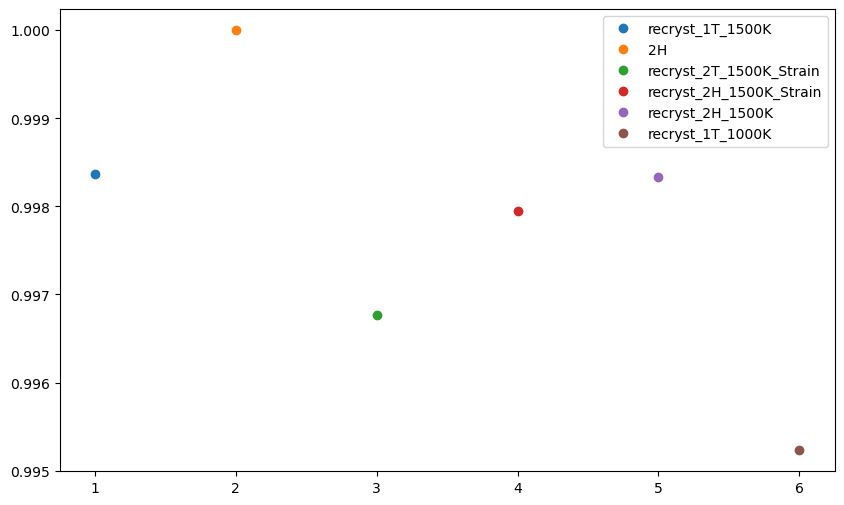

In [451]:
similarity = []

plt.figure(figsize=(10, 6))
for ic in range(1,7):
	sim = cosine_similarity(np.abs(descrptors['PCA'][0]).mean(axis=0).reshape(1, -1), np.abs(descrptors['PCA'][ic]).mean(axis=0).reshape(1, -1))
	similarity.append(sim)
	plt.plot(ic, sim, 'o', label=descrptors['structure'][ic])

plt.legend()

Structure :  1600000_2X_1T_1500K_scale.lmp | Hellinger Loss :  0.8981238353886779
Structure :  2X_2H_uc.lmp | Hellinger Loss :  0.7583803647640498
Structure :  1600000_2X_1T_1500K_scale1.0476.lmp | Hellinger Loss :  0.8316534085608086
Structure :  1600000_2X_2H_1500K_scale1.0476.lmp | Hellinger Loss :  0.8690804019542097
Structure :  1600000_2X_2H_1500K_scale1.lmp | Hellinger Loss :  0.8877320592770168
Structure :  1600000_2X_1T_1000K_scale.lmp | Hellinger Loss :  0.7907475931254323


/var/folders/11/20rr6pys3gq_ndbcqw57ny2r448330/T/ipykernel_15232/171445344.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pipeline.modifiers.append(CalculateBondAnglesAtParticle(center_particle = int(metal_idx[0]), mode = "Index", bond_mode = "Index"))


Text(0, 0.5, '')

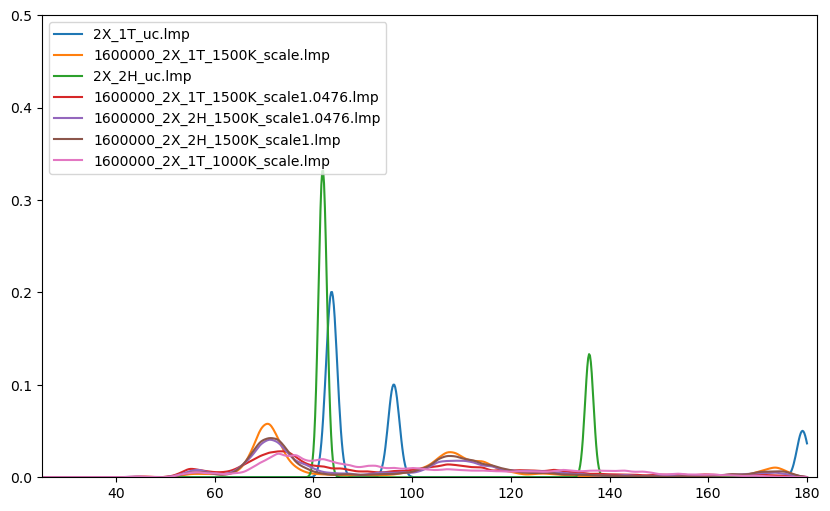

In [448]:
from ovito.io import import_file, export_file
from ovito.modifiers import BondAnalysisModifier, CreateBondsModifier
from scipy.stats import gaussian_kde

x_grid = np.linspace(0, 180, 1000)

plt.figure(figsize=(10, 6))
for ic, file in  enumerate(files):
	pipeline = import_file(file)
	pipeline.modifiers.append(CreateBondsModifier(cutoff = 3))
	pipeline.modifiers.append(BondAnalysisModifier(bins = 100))

	data = pipeline.compute()
	metal_idx = np.argwhere(data.particles.particle_types[...] == 1)
	# Calculate bond angles at particle:
	pipeline.modifiers.append(CalculateBondAnglesAtParticle(center_particle = int(metal_idx[0]), mode = "Index", bond_mode = "Index"))


	adf = data.tables['bond-angle-distr'].xy()
	data_adf = np.repeat(adf[:,0], adf[:,1].astype(int))
	kde = gaussian_kde(data_adf, bw_method=0.035)


	density = kde(x_grid)
	plt.plot(x_grid, density, label=file.split('/')[-1])
	if ic == 0:
		density_0 = density
	else:
		print ("Structure : ", file.split('/')[-1],"| Hellinger Loss : ", hellinger_from_kde(density, density_0, x_grid))
	# plt.plot(adf[:,0], adf[:,1]/adf[:,1].sum(), label=file.split('/')[-1])
plt.legend(loc='upper left')
plt.xlim(25, 182)
plt.ylim(0, .5)
plt.ylabel('')

In [346]:
descrptors['structure']

['1T',
 'recryst_1T_1500K',
 '2H',
 'recryst_2T_1500K_Strain',
 'recryst_2H_1500K_Strain',
 'recryst_2H_1500K',
 'recryst_1T_1000K']

/Users/sny/anaconda3/envs/auto_synth/lib/python3.11/site-packages/pymatgen/io/lammps/data.py:694: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(sio, header=None, comment="#", delim_whitespace=True)
/Users/sny/anaconda3/envs/auto_synth/lib/python3.11/site-packages/pymatgen/io/lammps/data.py:694: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(sio, header=None, comment="#", delim_whitespace=True)
/Users/sny/anaconda3/envs/auto_synth/lib/python3.11/site-packages/pymatgen/io/lammps/data.py:694: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(sio, header=None, comment="#", delim_whitespace=True)
/Users/sny/anaconda3/envs/auto_synth/lib/python3.11/site-pack

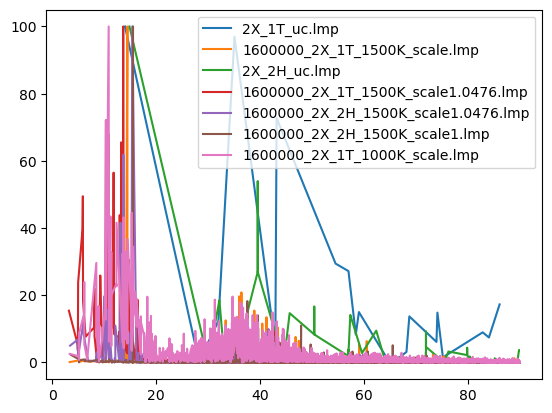

In [364]:
from pymatgen.io.lammps.data import LammpsData
from pymatgen.analysis.diffraction.xrd import XRDCalculator

for file in files:
	# XRD
	xrd = XRDCalculator(wavelength=1.5406)
	xrd.eta = 0.5
	xrd.sigma=0.6
	lmp_struc = LammpsData.from_file(file, atom_style='atomic').structure
	xrds = xrd.get_pattern(lmp_struc, two_theta_range=(0, 90))
	plt.plot(xrds.x, xrds.y, label=file.split('/')[-1])
plt.legend()